In [17]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# check whether cudnn available
# from torch.backends import cudnn
# cudnn.is_available()

#from torchnlp.datasets import multi30k_dataset
# train_set = multi30k_dataset(train=True)
# validation_set = multi30k_dataset(dev=True)
# test_set = multi30k_dataset(test=True)

# !pip uninstall spacy
# !pip install spacy
# !python3 -m spacy download de_core_news_sm
# !python3 -m spacy download en_core_web_sm
# import spacy
# import numpy as np
# from torchtext.legacy.datasets import Multi30k
# from torchtext.legacy.data import Field, BucketIterator

# spacy_de = spacy.load('de_core_news_sm')
# spacy_en = spacy.load('en_core_web_sm')


ModuleNotFoundError: No module named 'troch'

In [3]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

SRC = Field(tokenize = tokenize_de,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (SRC, TRG))

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")


NameError: name 'Field' is not defined

In [7]:
!pip install pytorch-nlp
from torchnlp.datasets import multi30k_dataset
train_set = multi30k_dataset(train=True)
validation_set = multi30k_dataset(dev=True)
test_set = multi30k_dataset(test=True)


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/


## Loading data file
file format: 
[{'en': 'A man in an orange hat starring at something.', 
'de': 'Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.'}, {}]

1. add SOS EOS
2. From unicode to acsii, delete lower case and trim punctuation.

In [8]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 20
EPOCH = 10
TRAINING_SIZE = -1

# build the dictionary
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter character
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def buildLangs(train_set, reverse=False):
    """ build Language dictionary
    Input: set and reverse flag. Default file from Eng>De.
        If we want to translate De->Eng, set reverse=True
    Output: two language dictionary class from training set
    """
    train_pairs = [[normalizeString(pair['en']), normalizeString(pair['de'])] \
        for pair in train_set[0:TRAINING_SIZE]]

    if reverse:
        train_pairs = [list(reversed(pair)) for pair in train_pairs]
        input_lang = Lang('en')
        output_lang = Lang('de')
    else: 
        input_lang = Lang('de')
        output_lang = Lang('en')
    return input_lang, output_lang, train_pairs

def prepareData(reverse=False):
    input_lang, output_lang, pairs = buildLangs(train_set, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData(reverse=True)
print(random.choice(pairs))

Read 28999 sentence pairs
Counting words...
Counted words:
en 16218
de 9124
['zwei frauen sitzen in einem treppenhaus in einem hauptsachlich wei geflie ten gebaude .', 'two females sitting on a stairwell in a mostly white tiled building .']


## Encoder and Decoder layer
A RNN network. Each timestep, input a word and then output a hidden state which used in next timestep input word. Need to implement forward calculation.

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size) 
        self.gru = nn.GRU(hidden_size, hidden_size) # gated recurrent unit

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1) # reshape the output
        output =embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class AttnDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        # TODO: figure out how to determine the size
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size*2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1,1,-1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Training
## Prepare the training data
Set the word to the index tensor.

In [10]:
# get index of word in sentence from dictionary
def indexFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

# return index tensor for pair
def tensorFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [11]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length = MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher = True if random.random() < teacher_forcing_ratio else False

    if use_teacher:
        for de in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[de])
            decoder_input = target_tensor[de]
    else:
        # Without teacher forcing: use its own predictions as the next input
        for de in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[de])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.item() / target_length

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.


In [28]:

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.02):
    start = time.time()
    plot_losses = []
    print_loss_total = 0 # reset every print_every
    plot_loss_total = 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate, momentum=0.3, nesterov=True)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate, momentum=0.3, nesterov=True)
    scheduler_en = optim.lr_scheduler.StepLR(encoder_optimizer, step_size=2, gamma=0.1)
    scheduler_de = optim.lr_scheduler.StepLR(decoder_optimizer, step_size=2, gamma=0.1)
    training_pairs = [tensorFromPair(random.choice(pairs)) for i in range(n_iters)]

    criterion = nn.NLLLoss()

    for iter in range(1, n_iters+1):
        training_pair = training_pairs[iter-1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer,\
            decoder_optimizer, criterion)
        # print("missing loss:",loss)

        print_loss_total += loss
        plot_loss_total += loss

        if iter % 29000 == 0:
            epoch_now = iter % 29000
            scheduler_de.step()
            scheduler_en.step()
            print('Epoch-{0} lr: {1}'.format(epoch_now, encoder_optimizer.param_groups[0]['lr']))
            encoder_save = './trained_model/encoder0603_epo='+str(epoch_now)+'.pth'
            decoder_save = './trained_model/attn0603_epo='+str(epoch_now)+'.pth'
            torch.save(encoder1.state_dict(), encoder_save)
            torch.save(attn_decoder1.state_dict(), decoder_save)

        if iter % print_every == 0:
            print_loss_avg = print_loss_total/print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters), \
                iter, iter / n_iters *100, print_loss_avg))
            showPlot(plot_losses)
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


In [19]:
import time
import math

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()
    plt.savefig('loss1')

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

0m 40s (- 193m 39s) (1000 0%) 4.9478


<Figure size 432x288 with 0 Axes>

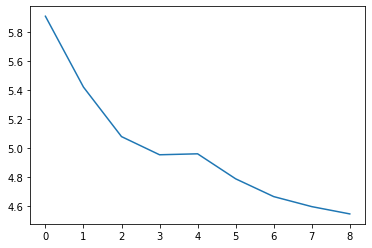

1m 8s (- 165m 13s) (2000 0%) 4.3013


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

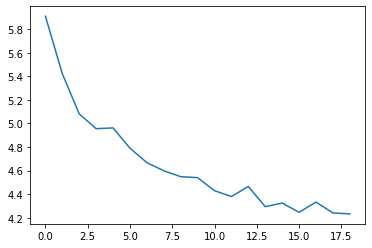

1m 37s (- 155m 20s) (3000 1%) 4.1265


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

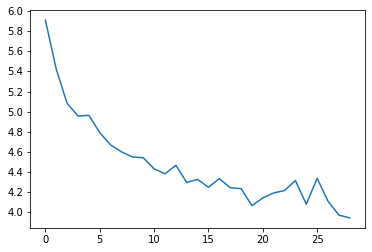

2m 6s (- 150m 15s) (4000 1%) 4.0647


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

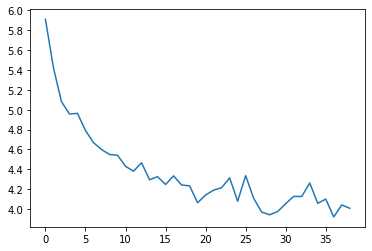

2m 35s (- 147m 44s) (5000 1%) 4.0571


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

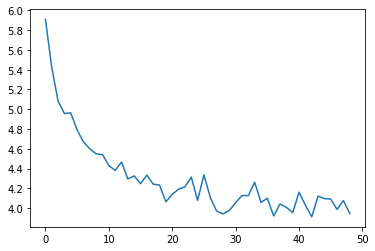

3m 4s (- 145m 24s) (6000 2%) 3.9597


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

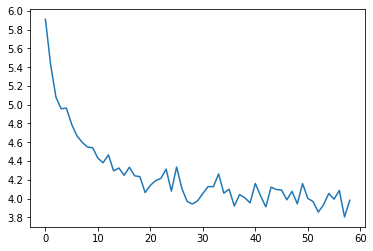

3m 33s (- 143m 49s) (7000 2%) 3.9297


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

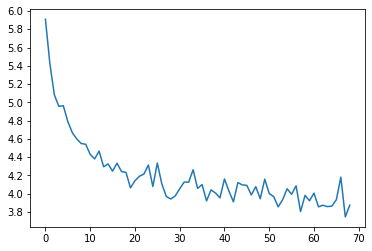

4m 2s (- 142m 26s) (8000 2%) 3.9128


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

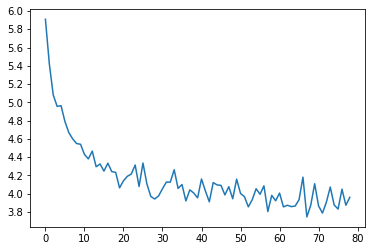

4m 31s (- 141m 10s) (9000 3%) 3.9071


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

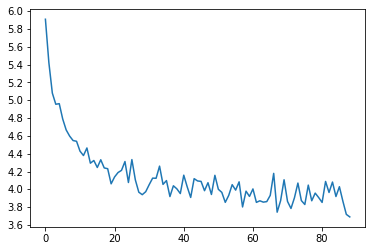

5m 0s (- 140m 8s) (10000 3%) 3.8799


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

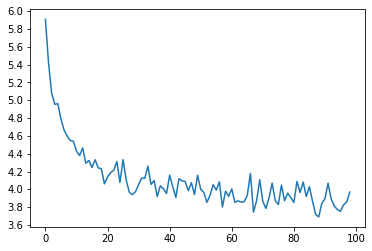

5m 29s (- 139m 21s) (11000 3%) 3.8304


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

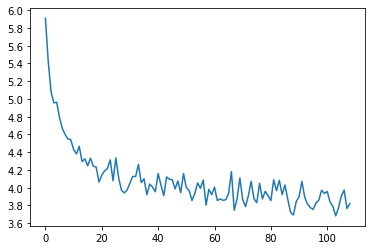

5m 58s (- 138m 31s) (12000 4%) 3.8543


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

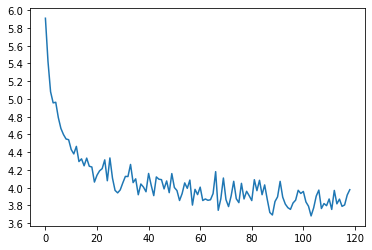

6m 27s (- 137m 45s) (13000 4%) 3.9175


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

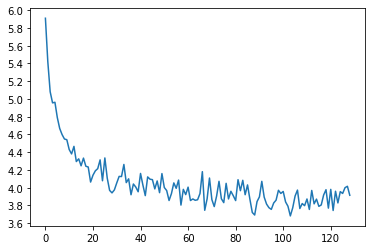

6m 57s (- 137m 3s) (14000 4%) 3.8543


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

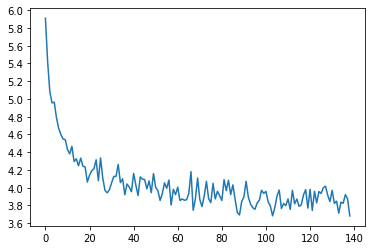

7m 26s (- 136m 18s) (15000 5%) 3.7963


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

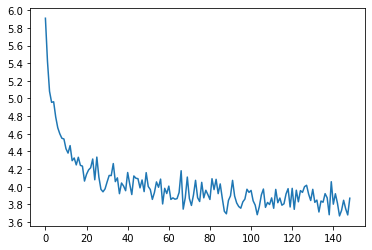

7m 55s (- 135m 35s) (16000 5%) 3.8452


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

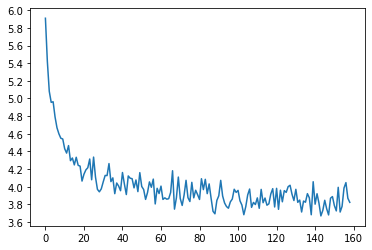

8m 24s (- 135m 3s) (17000 5%) 3.9131


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

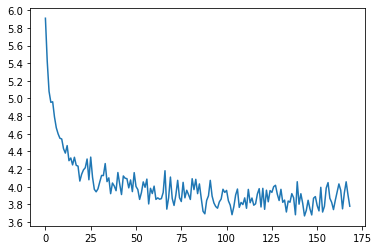

KeyboardInterrupt: 

In [26]:
%matplotlib inline

hidden_size = 512
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoder(hidden_size, output_lang.n_words, dropout_p=0.2).to(device)

trian_set_size = len(train_set)
trainIters(encoder1, attn_decoder1, EPOCH*trian_set_size, print_every=1000)

In [2]:
import torch
encoder_save = '/encoder0603_1.pth'
decoder_save = '/attn0603_1.pth'
torch.save(encoder1.state_dict(), encoder_save)
torch.save(attn_decoder1.state_dict(), decoder_save)

NameError: ignored

In [29]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

evaluateRandomly(encoder1, attn_decoder1)

> auf dieser belebten stra e in asien sind viele menschen .
= there are a lot of people on this busy asian street .
< one <EOS>

> mann auf hohem einrad in hellgelbem hemd rotem bandana und tarnhose jongliert mit drei kegeln wahrend leute zuschauen .
= man on a tall unicycle who is wearing bright yellow shirt red bandanna and camouflage pants is juggling pins while people watch .
< one <EOS>

> manner und frauen machen in einem offentlichen park yoga .
= men and women practice yoga in a public park .
< <EOS>

> ein kind sieht einer frau aufmerksam zu die ein macbook verwendet .
= a child watches intently as a woman uses a macbook laptop .
< one <EOS>

> ein junger mann mit einem rucksack tragt einen wei en pappkarton .
= a young man wearing a backpack is carrying a white cardboard box .
< <EOS>

> zwei kleine kinder klettern die stufen zu einem flugzeug hinauf .
= two small children climbing the steps onto a plane .
< one <EOS>

> ein alterer mann versucht herauszufinden was eine nahma

In [ ]:
"""
fail to run for now
"""
from BLEU.py import *
def run():
    source = '正因为你为你的玫瑰花费了时间,这才使你的玫瑰变得如此重要'  # source
    target = 'What makes your rose so important is the time you have wasted for it.'  # target
    inference = 'It is the time you have wasted for your rose that makes your rose so important.'  # inference
    bleu1 = BLEU(source, target, inference)
    bleu1.evaluate()
run()

ModuleNotFoundError: No module named 'jieba'